In [4]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [5]:
data_tst=pd.read_csv("GUIDE_Test.csv")

In [6]:
data_tst.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0.0,0.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0,Public


In [7]:
list(data_tst.columns)  # full column view

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'MitreTechniques',
 'IncidentGrade',
 'ActionGrouped',
 'ActionGranular',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'EmailClusterId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'ThreatFamily',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'ResourceType',
 'Roles',
 'OSFamily',
 'OSVersion',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict',
 'CountryCode',
 'State',
 'City',
 'Usage']

In [8]:
pd.set_option('display.max_columns', None)
data_tst.head(1)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,NaN,NaN,User,Impacted,98799.0,138268.0,360606.0,160396.0,2610.0,3699.0,425863.0,863.0,153085.0,529644.0,NaN,1631.0,635.0,860.0,2251.0,3421.0,881.0,NaN,289573.0,117668.0,3586.0,NaN,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Private


In [9]:
data_tst.shape

(79948, 46)

In [10]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79948 entries, 0 to 79947
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  79948 non-null  int64  
 1   OrgId               79948 non-null  int64  
 2   IncidentId          79948 non-null  int64  
 3   AlertId             79948 non-null  int64  
 4   Timestamp           79948 non-null  object 
 5   DetectorId          79948 non-null  int64  
 6   AlertTitle          79948 non-null  int64  
 7   Category            79948 non-null  object 
 8   MitreTechniques     35716 non-null  object 
 9   IncidentGrade       79948 non-null  object 
 10  ActionGrouped       33 non-null     object 
 11  ActionGranular      33 non-null     object 
 12  EntityType          79948 non-null  object 
 13  EvidenceRole        79948 non-null  object 
 14  DeviceId            79947 non-null  float64
 15  Sha256              79947 non-null  float64
 16  IpAd

# **Handling** **data**

In [11]:
threshold= len(data_tst)* 0.5   # removing 50% above null value
data_tst=data_tst.dropna(thresh=threshold,axis=1)

In [12]:
data_tst.shape

(79948, 36)

In [13]:
data_tst.duplicated().sum()

96

In [14]:
data_tst.drop_duplicates(inplace=True)

In [15]:
data_tst

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,BenignPositive,User,Impacted,98799.0,138268.0,360606.0,160396.0,2610.0,3699.0,425863.0,863.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239.0,138268.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,2833.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,0.0,0.0,242.0,1445.0,10630.0,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,BenignPositive,Process,Related,98799.0,4296.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,14.0,22.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799.0,138268.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,BenignPositive,User,Impacted,98799.0,138268.0,360606.0,160396.0,133549.0,673934.0,425863.0,136104.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79943,481036341178,24,462062,338045,2024-06-04T23:26:40.000Z,5,21,SuspiciousActivity,TruePositive,Ip,Related,98799.0,138268.0,10114.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private
79944,42949674863,134,98613,452716,2024-06-13T04:39:46.000Z,6,5,InitialAccess,BenignPositive,MailCluster,Related,98799.0,138268.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public
79945,1683627184870,334,248134,896298,2024-06-10T16:30:04.000Z,4,3,InitialAccess,BenignPositive,CloudLogonRequest,Related,98799.0,138268.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private
79946,395136993207,134,77669,669267,2024-06-04T21:45:39.000Z,820,1162,Discovery,FalsePositive,Ip,Related,98799.0,138268.0,32553.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public


In [16]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79852 entries, 0 to 79947
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  79852 non-null  int64  
 1   OrgId               79852 non-null  int64  
 2   IncidentId          79852 non-null  int64  
 3   AlertId             79852 non-null  int64  
 4   Timestamp           79852 non-null  object 
 5   DetectorId          79852 non-null  int64  
 6   AlertTitle          79852 non-null  int64  
 7   Category            79852 non-null  object 
 8   IncidentGrade       79852 non-null  object 
 9   EntityType          79852 non-null  object 
 10  EvidenceRole        79852 non-null  object 
 11  DeviceId            79851 non-null  float64
 12  Sha256              79851 non-null  float64
 13  IpAddress           79851 non-null  float64
 14  Url                 79851 non-null  float64
 15  AccountSid          79851 non-null  float64
 16  AccountUp

In [17]:
#mode imputation because of catagorial columns

data_tst["IncidentGrade"].fillna(data_tst["IncidentGrade"].mode()[0],inplace=True)

<ipython-input-17-250e31f5011d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tst["IncidentGrade"].fillna(data_tst["IncidentGrade"].mode()[0],inplace=True)


In [18]:
data_tst['Timestamp']=pd.to_datetime(data_tst['Timestamp']) # data clean Timestamp

In [19]:
data_tst['Timestamp'].head()

,Timestamp
0,2024-06-04 22:56:27+00:00
1,2024-06-03 12:58:26+00:00
2,2024-06-08 03:20:49+00:00
3,2024-06-12 12:07:31+00:00
4,2024-06-06 17:42:05+00:00


In [20]:
data_tst["Day"]=data_tst["Timestamp"].dt.day
data_tst["Month"]=data_tst["Timestamp"].dt.month
data_tst["Year"]=data_tst["Timestamp"].dt.year
data_tst["Hour"]=data_tst["Timestamp"].dt.hour
data_tst["Time"]=data_tst["Timestamp"].dt.time

In [21]:
[features for features in data_tst.columns if data_tst[features].isnull().sum()>0]

['DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'OSFamily',
 'OSVersion',
 'CountryCode',
 'State',
 'City',
 'Usage']

In [22]:
data_tst.drop("Timestamp",axis=1,inplace=True)  # doprring timestamp column
print(data_tst.head())

              Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
0  1245540519230    657       11767    87199         524         563   
1  1400159342154      3       91158   632273           2           2   
2  1279900255923    145       32247   131719        2932       10807   
3    60129547292    222       15294   917686           0           0   
4   515396080539    363        7615     5944          27          18   

            Category   IncidentGrade         EntityType EvidenceRole  \
0    LateralMovement  BenignPositive               User     Impacted   
1  CommandAndControl  BenignPositive            Machine     Impacted   
2    LateralMovement  BenignPositive            Process      Related   
3      InitialAccess   FalsePositive  CloudLogonSession      Related   
4          Discovery  BenignPositive               User     Impacted   

   DeviceId    Sha256  IpAddress       Url  AccountSid  AccountUpn  \
0   98799.0  138268.0   360606.0  160396.0      2610.0      3699

In [23]:
pd.set_option("display.max_columns", None)
data_tst.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799.0,138268.0,360606.0,160396.0,2610.0,3699.0,425863.0,863.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239.0,138268.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,2833.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,0.0,0.0,242.0,1445.0,10630.0,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799.0,4296.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,14.0,22.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799.0,138268.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799.0,138268.0,360606.0,160396.0,133549.0,673934.0,425863.0,136104.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,6,6,2024,17,17:42:05


In [24]:
data_tst['IncidentGrade'].value_counts()

,count
IncidentGrade,
BenignPositive,33711
TruePositive,28796
FalsePositive,17345


In [25]:
data_tst.IncidentGrade.unique()

array(['BenignPositive', 'FalsePositive', 'TruePositive'], dtype=object)

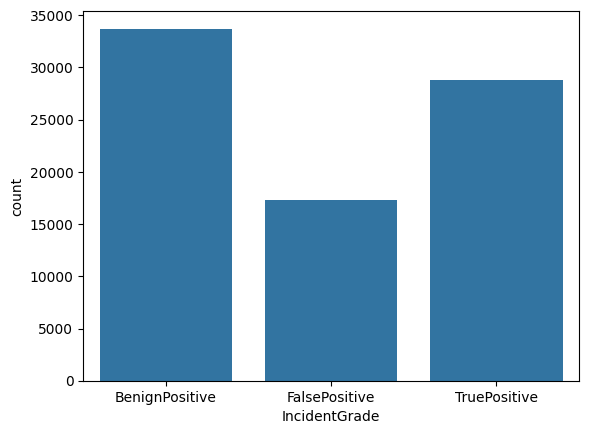

In [26]:
# Distribution of target variable
sns.countplot(x="IncidentGrade", data=data_tst)
plt.show()

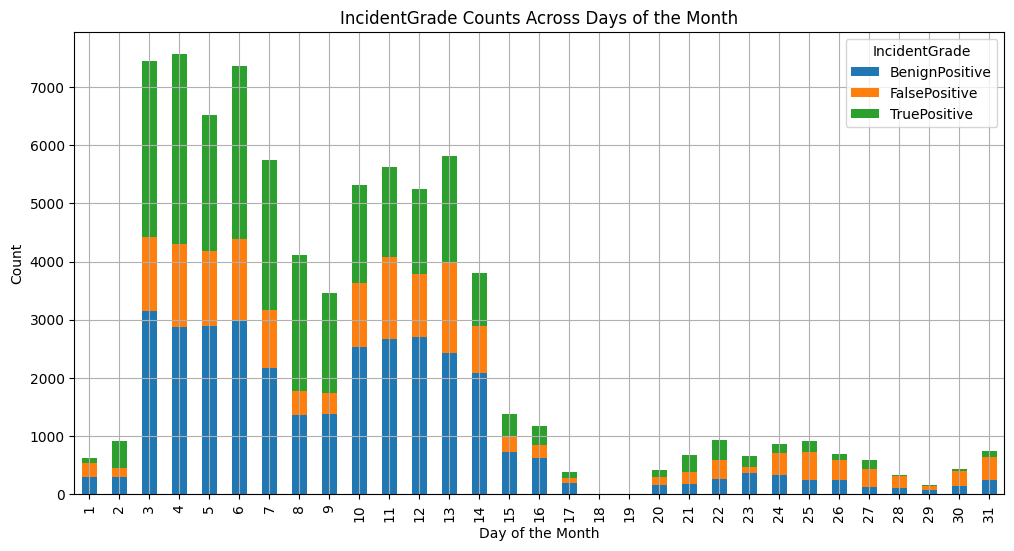

In [27]:
# Aggregate data
day_incident_grade = data_tst.groupby(['Day', 'IncidentGrade']).size().unstack()

# Plot
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

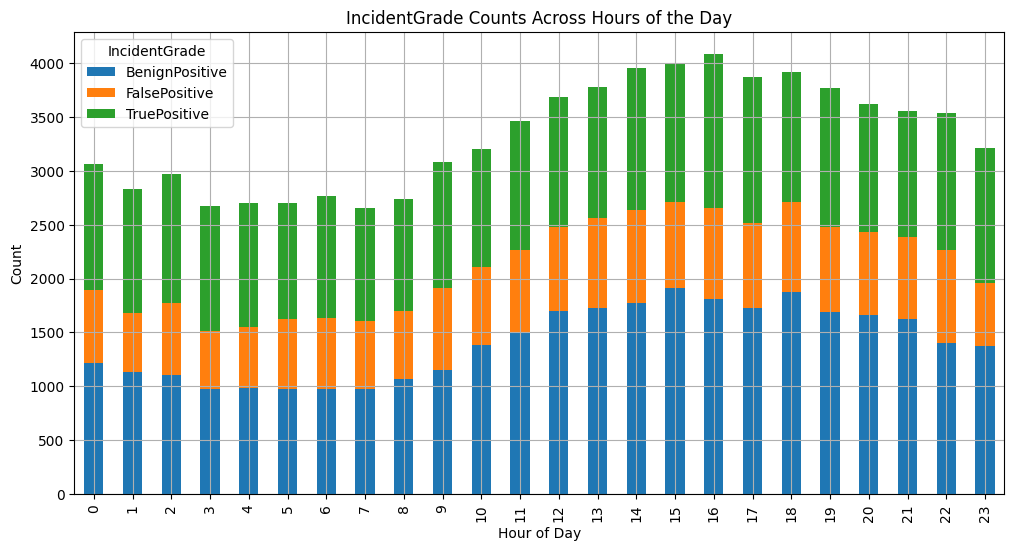

In [28]:
# Aggregate data

hour_incident =data_tst.groupby(['Hour', 'IncidentGrade']).size().unstack()

hour_incident.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Hour of Day")
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Hours of the Day')
plt.legend(title="IncidentGrade")
plt.grid(True)
plt.show()

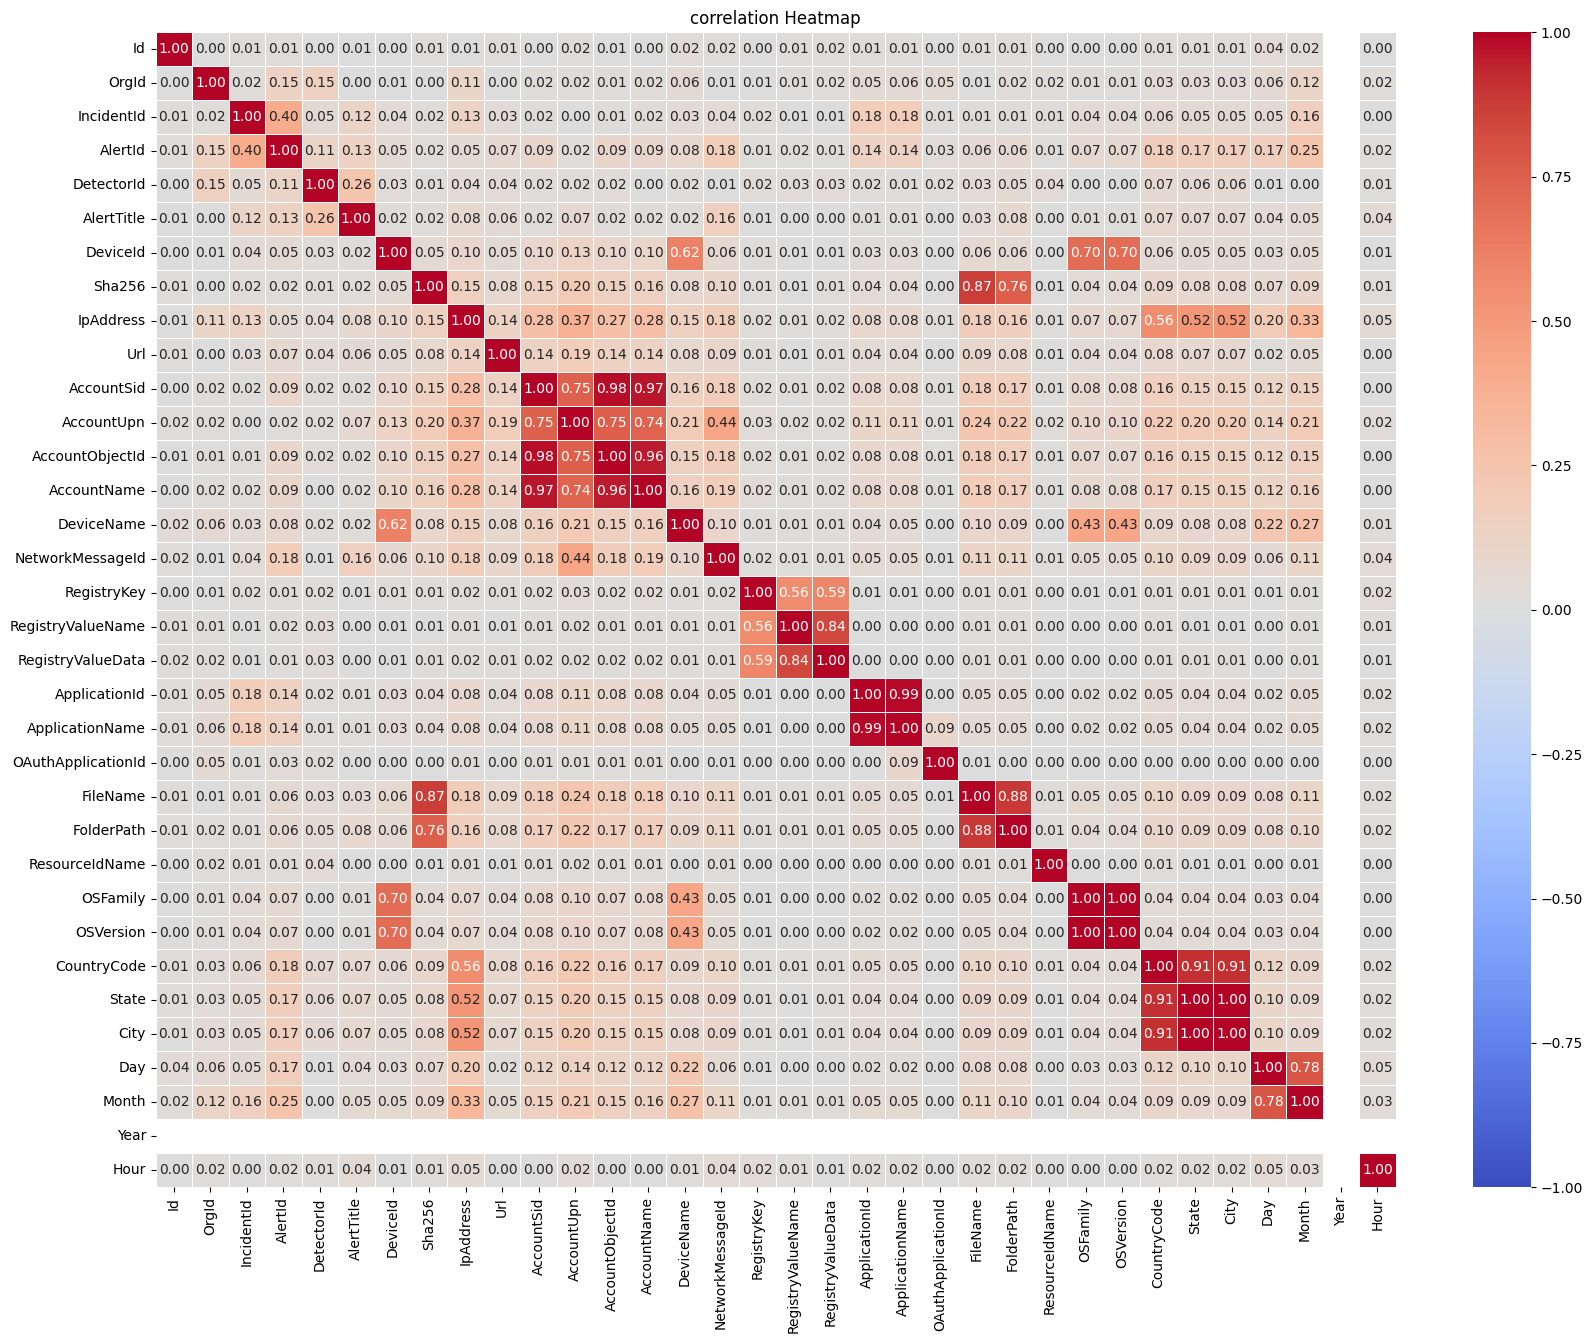

In [29]:
# selecting numerical col
numeric_df=data_tst.select_dtypes(include=['number'])

corr_matrix= numeric_df.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [30]:
# dropping 70% above correlated columns
data_tst.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","OSFamily","OSVersion","AccountObjectId","State","FolderPath","AccountUpn"], axis =1 , inplace = True)

In [31]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799.0,360606.0,160396.0,863.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239.0,360606.0,160396.0,453297.0,2833.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,14.0,3586.0,10630.0,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799.0,360606.0,160396.0,136104.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,6,6,2024,17,17:42:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79943,481036341178,24,462062,338045,5,21,SuspiciousActivity,TruePositive,Ip,Related,98799.0,10114.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Private,4,6,2024,23,23:26:40
79944,42949674863,134,98613,452716,6,5,InitialAccess,BenignPositive,MailCluster,Related,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,13,6,2024,4,04:39:46
79945,1683627184870,334,248134,896298,4,3,InitialAccess,BenignPositive,CloudLogonRequest,Related,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Private,10,6,2024,16,16:30:04
79946,395136993207,134,77669,669267,820,1162,Discovery,FalsePositive,Ip,Related,98799.0,32553.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,4,6,2024,21,21:45:39


# **Encoding**

In [32]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79852 entries, 0 to 79947
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  79852 non-null  int64  
 1   OrgId               79852 non-null  int64  
 2   IncidentId          79852 non-null  int64  
 3   AlertId             79852 non-null  int64  
 4   DetectorId          79852 non-null  int64  
 5   AlertTitle          79852 non-null  int64  
 6   Category            79852 non-null  object 
 7   IncidentGrade       79852 non-null  object 
 8   EntityType          79852 non-null  object 
 9   EvidenceRole        79852 non-null  object 
 10  DeviceId            79851 non-null  float64
 11  IpAddress           79851 non-null  float64
 12  Url                 79851 non-null  float64
 13  AccountName         79851 non-null  float64
 14  DeviceName          79851 non-null  float64
 15  NetworkMessageId    79851 non-null  float64
 16  RegistryK

In [33]:
data_tst.select_dtypes(include=["object"]).columns

Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Time'],
      dtype='object')

In [34]:
Categorical_colts=['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Time']

# **Label** **encoder**

In [35]:
encoders = {}
for i in Categorical_colts:
    # Convert the 'Time' column to strings before applying LabelEncoder
    if i == 'Time':
        data_tst[i] = data_tst[i].astype(str)
    le = LabelEncoder()
    data_tst[i] = le.fit_transform(data_tst[i])
    encoders[i] = le

In [36]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,22,0,98799.0,360606.0,160396.0,863.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,4,6,2024,22,42423
1,1400159342154,3,91158,632273,2,2,1,0,10,0,1239.0,360606.0,160396.0,453297.0,2833.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,3,6,2024,12,22106
2,1279900255923,145,32247,131719,2932,10807,11,0,17,2,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,14.0,3586.0,10630.0,1,8,6,2024,3,5689
3,60129547292,222,15294,917686,0,0,10,1,6,2,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,12,6,2024,12,20398
4,515396080539,363,7615,5944,27,18,5,0,22,0,98799.0,360606.0,160396.0,136104.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,6,6,2024,17,32084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79943,481036341178,24,462062,338045,5,21,16,2,9,2,98799.0,10114.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,4,6,2024,23,43336
79944,42949674863,134,98613,452716,6,5,10,0,11,2,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,13,6,2024,4,7850
79945,1683627184870,334,248134,896298,4,3,10,0,5,2,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,10,6,2024,16,29570
79946,395136993207,134,77669,669267,820,1162,5,1,9,2,98799.0,32553.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,4,6,2024,21,40237


In [37]:
data_tst.select_dtypes(include=["int32", "int64"]).columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Day', 'Month', 'Year', 'Hour', 'Time'],
      dtype='object')

In [38]:
data_tst1=data_tst.copy()

In [39]:
data_tst1.to_csv('/content/mtest_process.csv',index= False)

In [40]:
data_tst1.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,22,0,98799.0,360606.0,160396.0,863.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,4,6,2024,22,42423
1,1400159342154,3,91158,632273,2,2,1,0,10,0,1239.0,360606.0,160396.0,453297.0,2833.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,3,6,2024,12,22106
2,1279900255923,145,32247,131719,2932,10807,11,0,17,2,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,14.0,3586.0,10630.0,1,8,6,2024,3,5689
3,60129547292,222,15294,917686,0,0,10,1,6,2,98799.0,360606.0,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,12,6,2024,12,20398
4,515396080539,363,7615,5944,27,18,5,0,22,0,98799.0,360606.0,160396.0,136104.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,6,6,2024,17,32084


In [41]:
from imblearn.over_sampling import RandomOverSampler

In [42]:
os =RandomOverSampler(random_state = 45)

In [43]:
val =data_tst1.drop('IncidentGrade', axis =1)

In [44]:
tar = data_tst1['IncidentGrade']

In [45]:
tar.value_counts()

,count
IncidentGrade,
0,33711
2,28796
1,17345


In [46]:
oval,otar = os.fit_resample(val,tar)

In [47]:
otar.value_counts()

,count
IncidentGrade,
0,33711
1,33711
2,33711


# **Feature** **selection**

In [48]:
fs = RandomForestClassifier(n_estimators = 300, random_state =56)

In [49]:
fs.fit(oval,otar)

RandomForestClassifier(n_estimators=300, random_state=56)

In [50]:
pd.DataFrame({
    "columns": oval.columns,
    "Score": fs.feature_importances_
}).sort_values('Score', ascending =False).head(15)["columns"].to_list()

['OrgId',
 'IncidentId',
 'DetectorId',
 'AlertId',
 'AlertTitle',
 'Id',
 'Day',
 'Category',
 'Time',
 'Hour',
 'AccountName',
 'EntityType',
 'IpAddress',
 'NetworkMessageId',
 'FileName']

In [51]:
oval=oval[['OrgId',
 'IncidentId',
 'DetectorId',
 'AlertId',
 'AlertTitle',
 'Id',
 'Day',
 'Category',
 'Time',
 'Hour',
 'AccountName',
 'EntityType',
 'IpAddress',
 'DeviceName',
 'FileName']]

In [52]:
# Train Test Split
traindata,testdata, trainlab,testlab = train_test_split(oval,otar, test_size = 0.20, random_state = 43)

In [53]:
traindata.shape

(80906, 15)

In [54]:
testdata.shape

(20227, 15)

# **Model** **building**

In [56]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

In [57]:
dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")

In [58]:
dt_model.fit(traindata,trainlab)

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=100)

In [59]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100

    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [60]:
dttr_pred =dt_model.predict(traindata)
dtts_pred =dt_model.predict(testdata)

In [61]:
dttrain_metrics=metrics(trainlab,dttr_pred)

In [62]:

dttest_metrics=metrics(testlab,dtts_pred)

In [63]:
pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,69.819296,69.130370
1,Precision,79.261190,78.972432
2,Recall,69.813911,69.153407
3,Macro F1,70.005847,69.268097


In [64]:
# RANDOM FOREST
rfc =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)

In [65]:

rfc.fit(traindata,trainlab)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [66]:
rftr_pred =rfc.predict(traindata)
rfts_pred =rfc.predict(testdata)

In [67]:
rftrain_metrics=metrics(trainlab,rftr_pred)
rftest_metrics=metrics(testlab,rfts_pred)

In [68]:
pd.DataFrame({
    "Training":rftrain_metrics["Values"],
    "Testing":rftest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,80.907473,79.611410
1,Precision,85.693554,84.624528
2,Recall,80.909762,79.603614
3,Macro F1,81.307424,80.013764


# **XGBoost**

In [70]:
# XGBoost
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [71]:
xgbmodel.fit(traindata,trainlab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [72]:
xgbtr_pred =xgbmodel.predict(traindata)
xgbts_pred =xgbmodel.predict(testdata)

In [73]:
xgbtrain_metrics = metrics(trainlab,xgbtr_pred)
xgbtest_metrics =metrics(testlab,xgbts_pred)

In [74]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,96.217833,93.320809
1,Precision,96.237887,93.390461
2,Recall,96.219408,93.309616
3,Macro F1,96.219912,93.324120
